In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import seaborn as sns

import xgboost
from sklearn import metrics
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score

kfold = KFold(n_splits=5, random_state=42)
break_point = datetime(2017, 2, 28)

In [2]:
def read_data():
    
    print('Reading files...')    
    order_df = pd.read_csv('../input/machine_learning_challenge_order_data.csv')
    print('Order data has {} rows and {} columns'.format(order_df.shape[0], order_df.shape[1]))
    label_df = pd.read_csv('../input/machine_learning_challenge_labeled_data.csv')
    print('Label data has {} rows and {} columns'.format(label_df.shape[0], label_df.shape[1]))
    df = order_df.merge(label_df, on='customer_id')
    return df

In [3]:
def reduce_mem_usage(df, verbose=False):
    
    start_mem = df.memory_usage().sum() / 1024 ** 2
    int_columns = df.select_dtypes(include=["int"]).columns
    float_columns = df.select_dtypes(include=["float"]).columns

    for col in int_columns:
        df[col] = pd.to_numeric(df[col], downcast="integer")

    for col in float_columns:
        df[col] = pd.to_numeric(df[col], downcast="float")

    end_mem = df.memory_usage().sum() / 1024 ** 2
    if verbose:
        print(
            "Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)".format(
                end_mem, 100 * (start_mem - end_mem) / start_mem
            )
        )
    return df

In [4]:
def getWeeklyDates(df, break_point):

    df['order_date'] = pd.to_datetime(df['order_date'])
    three_day = df[df['order_date'] >= break_point - timedelta(days=3)]
    one_week = df[df['order_date'] >= break_point - timedelta(days=7)]
    two_week = df[df['order_date'] >= break_point - timedelta(days=14)]
    four_week = df[df['order_date'] >= break_point - timedelta(days=28)]
    twelve_week = df[df['order_date'] >= break_point - timedelta(days=84)]
    twenty_four_week = df[df['order_date'] >= break_point - timedelta(days=168)]
    all_week = df
    return three_day, one_week, two_week, four_week, twelve_week, twenty_four_week,all_week

In [5]:
def transform_data(df):

    labelencoder = LabelEncoder()

    for i in ['restaurant_id', 'city_id', 'payment_id', 'platform_id', 'transmission_id']:
        df[i] = labelencoder.fit_transform(df[i])

    return df

In [6]:
def feature_engineering(df, break_point):
    
    df['customer_order_rank'] = df['customer_order_rank'].fillna(method='ffill')

    df['date'] = pd.to_datetime(df['order_date']) 
    df['recency'] = (break_point - df['date']) / np.timedelta64(1, 'D')
    df['first_order_date'] = df.groupby(['customer_id'])['date'].transform('first')
    df['age_of_user'] = (break_point - df['first_order_date']) / np.timedelta64(1, 'D')

    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['week'] = df['date'].dt.week
    df['day'] = df['date'].dt.day
    df['dayofweek'] = df['date'].dt.dayofweek
    df["is_weekend"] = df["dayofweek"].isin([5, 6]).astype(np.int8)
    
    df['demand'] = 1
    
    df['order_date_shift'] = df.groupby('customer_id')['date'].shift()
    df['date_diff'] = (df['date'] - df['order_date_shift']) / np.timedelta64(1, 'D')

    three_day, one_week, two_week, four_week, twelve_week, twenty_four_week,all_week = getWeeklyDates(df, break_point)
    
    col = ['demand', 'is_failed','voucher_amount','delivery_fee', 'amount_paid', 'date_diff']
    three_day, one_week, two_week, four_week, twelve_week, twenty_four_week,all_week = getWeeklyDates(df, break_point)
    three_day = three_day.groupby('customer_id')[col].mean().add_prefix('three_day_').reset_index()
    one_week = one_week.groupby('customer_id')[col].mean().add_prefix('one_week_').reset_index()
    two_week = two_week.groupby('customer_id')[col].mean().add_prefix('two_week_').reset_index()
    four_week = four_week.groupby('customer_id')[col].mean().add_prefix('four_week_').reset_index()
    twelve_week = twelve_week.groupby('customer_id')[col].mean().add_prefix('twelve_week_').reset_index()
    twenty_four_week = twenty_four_week.groupby('customer_id')[col].mean().add_prefix('twenty_four_week_').reset_index()
    all_week = all_week.groupby('customer_id')[col].mean().add_prefix('all_week_').reset_index()
    
    df = df.groupby('customer_id').last().reset_index()
    df = df.merge(three_day, how='left').merge(one_week, how='left').merge(two_week, how='left').merge(four_week,
    'left').merge(twelve_week,'left').merge(twenty_four_week,'left').merge(all_week,'left').reset_index()

    return df

In [7]:
def run_lgb(df):
    
    y = df['is_returning_customer']
    X = df.drop(columns=['customer_id', 'order_date', 'date', 'is_returning_customer',
                        'first_order_date', 'index', 'order_date_shift'])    
    
    clf = xgboost.XGBClassifier(objective= 'binary:logistic', n_jobs= -1
                               )
    clf.fit(X, y)
    
    y_pred = cross_val_predict(clf, X, y, cv=kfold)
    
    predicted = pd.DataFrame(y_pred, index=df.customer_id, columns=['y_pred']).reset_index()
    predicted['y_actual'] = y
    predicted = predicted.merge(df[['customer_id', 'customer_order_rank','recency']], on='customer_id')
    #predicted.to_csv('pred.csv')

    print('Accuracy Score:  ', round(metrics.accuracy_score(y, y_pred), 2))
    print('Roc Auc Score:  ', round(roc_auc_score(y, y_pred), 2))
    print('Classification Report: \n', classification_report(y, y_pred, target_names=['0', '1']))
    return predicted

In [8]:
def transform_train_and_eval():
    
    df = read_data()
    df = reduce_mem_usage(df, True)
    df = transform_data(df)
    df = feature_engineering(df, break_point)
    predicted = run_lgb(df)
    return predicted

predicted = transform_train_and_eval()

Reading files...
Order data has 786600 rows and 13 columns
Label data has 245455 rows and 2 columns
Mem. usage decreased to 42.76 Mb (52.5% reduction)
Accuracy Score:   0.84
Roc Auc Score:   0.7
Classification Report: 
               precision    recall  f1-score   support

           0       0.85      0.96      0.90    189948
           1       0.75      0.44      0.55     55507

   micro avg       0.84      0.84      0.84    245455
   macro avg       0.80      0.70      0.73    245455
weighted avg       0.83      0.84      0.82    245455



In [9]:
order_bins = [0, 1, 4, 9, 49, 99, 999]
order_labels = ["1", "2-4", "5-9", "10-49", "50-99", "100+"]
predicted['order_binned'] = pd.cut(predicted['customer_order_rank'], bins=order_bins, labels=order_labels)

recency_bins = [0, 7, 14, 28, 84, 168, 1680]
recency_labels = ["0-7", "8-14", "15-28", "29-84", "85-168", "168+"]
predicted['recency_binned'] = pd.cut(predicted['recency'], bins=recency_bins, labels=recency_labels)

predicted['is_true'] = np.where(predicted.y_pred==predicted.y_actual, 1, 0)

result_probs = predicted.pivot_table(columns='order_binned', 
                                     index='recency_binned', values='y_pred', aggfunc='mean')
result_count = predicted.pivot_table(columns='order_binned', 
                                     index='recency_binned', values='y_pred', aggfunc='count')
result_performance = predicted.pivot_table(columns='order_binned', 
                                     index='recency_binned', values='is_true', aggfunc='mean')

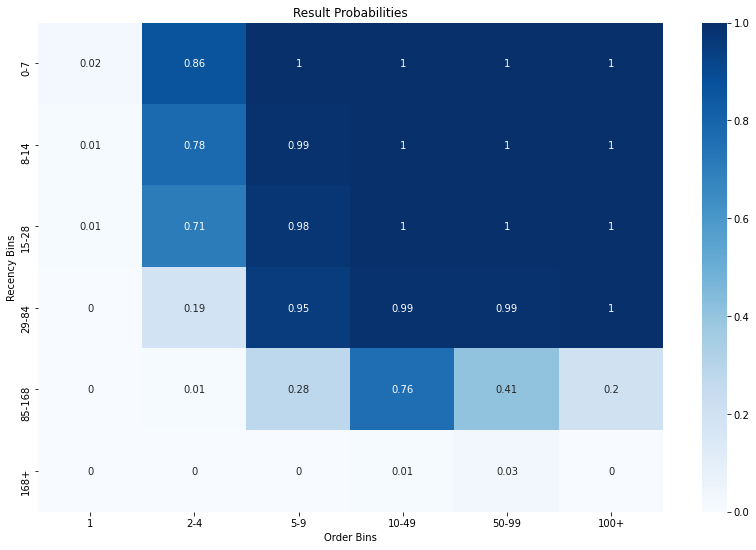

In [10]:
plt.figure(figsize = (14, 9))
plt.title('Result Probabilities')
sns.heatmap(data = round(result_probs, 2), annot = True, cmap='Blues', fmt='g')
plt.xlabel('Order Bins')
plt.ylabel('Recency Bins')
plt.show()

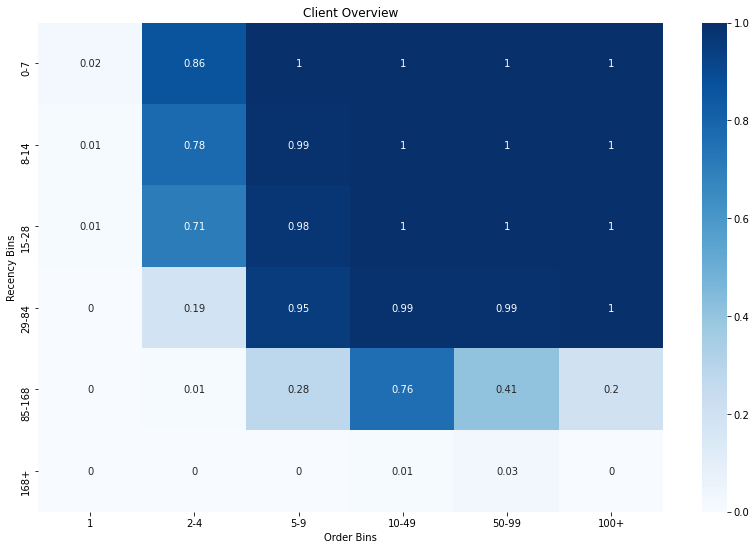

In [11]:
plt.figure(figsize = (14, 9))
plt.title('Client Overview')
sns.heatmap(data = round(result_probs, 2), annot = True, cmap='Blues', fmt='g')
plt.xlabel('Order Bins')
plt.ylabel('Recency Bins')
plt.show()

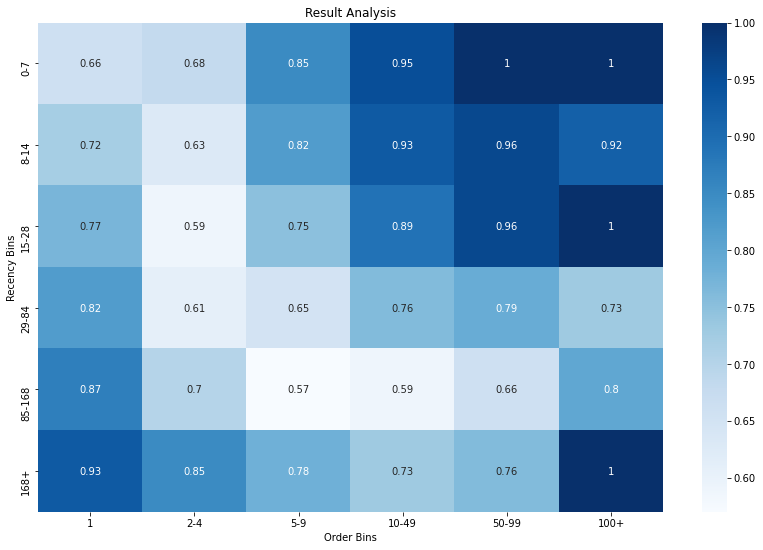

In [12]:
plt.figure(figsize = (14, 9))
plt.title('Result Analysis')
sns.heatmap(data = round(result_performance, 2), annot = True, cmap='Blues', fmt='g')
plt.xlabel('Order Bins')
plt.ylabel('Recency Bins')
plt.show()